# pronóstico de series de tiempo

En esta notebook vamos a realizar el pronóstico de una serie de tiempo
1. Descargaremos los datos
2. Graficaremos la series para darnos una idea de su comportamiento
3. realizaremos una prueba de raíz unitaria para comprobrar si la serie es estacionaria
4. Diferenciaremos la serie en caso de que no sea estacionaria
5. Realizamos la prueba a la serie diferenciada para ver si es estacionaria
6. Graficaremos la serie estacionaria
7. realizaremos su ACF y PACF para tratar de identificar que tipo de proceso es MA(q), AR(P), ARMA(p,q), etc
8. Estimamos distintos modelos
9. Elegimos el modelo
10. Realizamos el pronóstico 

In [2]:
pip install yfinance

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=aa6b1b04706522d08a3c963d988e428f14eb3e265d0124111c297f36c3f1ca84
  Stored in directory: c:\users\aaron\appdata\local\pip\cache\wheels\f2\b5\2c\59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking
Note: you may need to restart the kernel to use updated packages.


In [3]:
# como siempre comenzamos importando las librerias
import numpy as np
import pandas as pd 
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA


%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [4]:
#fijamos tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7.5]

## 1. Importamos los datos desde la api de yahoo finance

en mi caso yo voy a utilizar las acciones de walmart de México y voy a utilizar la información de los ultimos dos años hasta el día viernes, que es cuando estuvo abierta la bolsa

In [5]:
#recuerda instalar yahoo finance con-> pip install yfinance
intel = yf.download('INTC', 
                       start='2019-09-01', 
                       end='2022-03-12',
                       progress=False)

In [7]:
#vemos los ultimos 10 datos
intel.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-28,47.000000,47.820000,46.849998,47.700001,47.700001,41920000
2022-03-01,47.540001,47.900002,46.220001,46.820000,46.820000,53853000
2022-03-02,47.520000,48.990002,47.480000,48.869999,48.869999,46936500
2022-03-03,48.180000,48.549999,47.619999,47.930000,47.930000,36389900
2022-03-04,47.369999,48.270000,47.369999,48.070000,48.070000,38310700
2022-03-07,48.009998,48.540001,47.599998,47.680000,47.680000,43813700
2022-03-08,47.689999,48.720001,46.889999,47.500000,47.500000,44813900
2022-03-09,48.410000,48.459999,46.889999,47.630001,47.630001,36076500
2022-03-10,47.290001,47.310001,46.160000,46.660000,46.660000,36456000


In [8]:
##Voy renombar columna 'Adj Close' por adj_close 
intel.rename(columns = {'Adj Close':'adj_close'}, inplace=True)

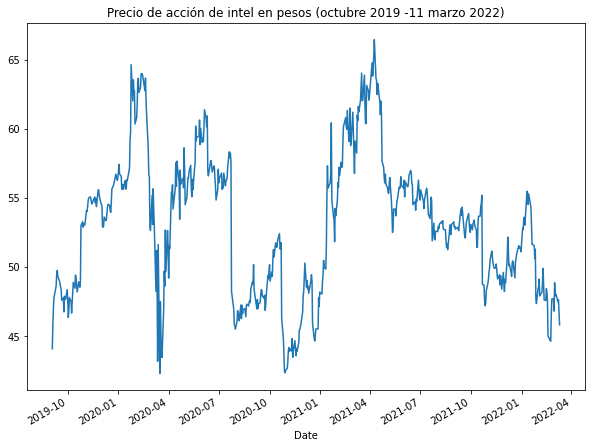

In [9]:
# vamos a graficar
intel.adj_close.plot()
plt.title('Precio de acción de intel en pesos (octubre 2019 -11 marzo 2022)')
plt.show()

In [10]:
#hacemos la prueba de dickey fuller aumentada ADF
adf = adfuller(intel['adj_close'])

#presentamos el p-value
print('p-value: %f' % adf[1])



p-value: 0.039048


Recuerda que $H_0$: serie no estacionaria

In [11]:
if adf[1] < 0.05:
    
    print(f'con un un p-value={adf[1].round(3)}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf[1].round(3)}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value=0.039
 Se rechaza hipótesis nula, serie estacionaria


para hacer la serie estacionaria, usaremos lafunción shift de pandas 

y guardaremos la serie diferenciada en un objeto aparte

In [12]:
intel_diff = intel['adj_close'] - intel['adj_close'].shift()

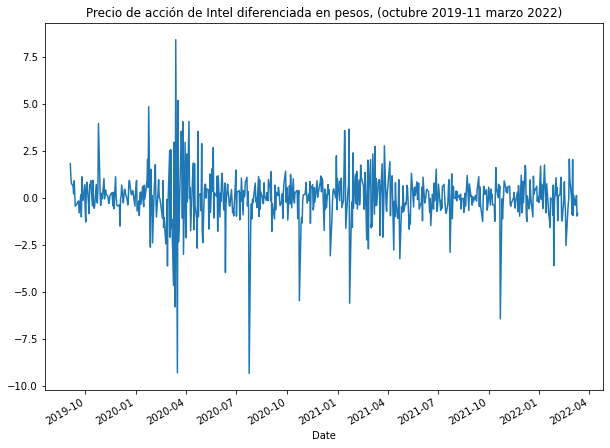

In [13]:
#graficamos el tipo de cambio diferenciado
intel_diff.plot()
plt.title('Precio de acción de Intel diferenciada en pesos, (octubre 2019-11 marzo 2022)')
plt.show()

In [14]:
#eliminamos los Nan
intel_diff = intel_diff.dropna()

In [15]:
## como la serie tiene saltos (los fines de semana los mercados no abren)
## removeremos la fecha
intel_diff = intel_diff.reset_index()

### eliminamos columna fecha
intel_diff = intel_diff.drop(['Date'], axis=1)

In [16]:
intel_diff

,adj_close
0,1.821125
1,1.107689
2,0.769753
3,0.628941
4,0.215908
...,...
631,-0.389999
632,-0.180000
633,0.130001
634,-0.970001


volvemos a realizar la prueba de raíz unitaria ADF

In [17]:
adf1 = adfuller(intel_diff)
if adf1[1] < 0.05:
    
    print(f'con un un p-value={adf1[1]}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf1[1]}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value=1.050640921616083e-12
 Se rechaza hipótesis nula, serie estacionaria


Ahora que la serie ya es estacionaria, podemos hacer pronósticos con ella
por tanto debemos identificar que tipo de proceso es


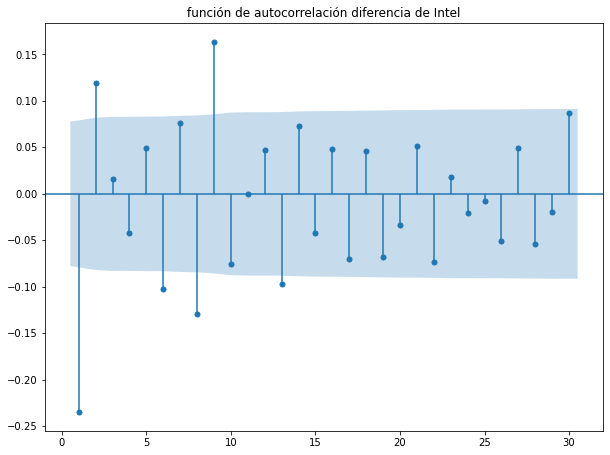

In [18]:
#grafica de autocorrelación ACF
plot_acf(intel_diff, zero=False, lags=30)
plt.title('función de autocorrelación diferencia de Intel')
plt.show()

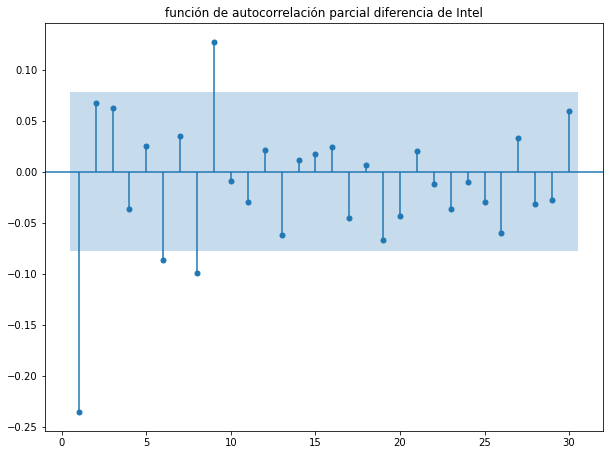

In [19]:
#grafica de autocorrelación parcial PACF
plot_pacf(intel_diff, zero=False, lags=30)
plt.title('función de autocorrelación parcial diferencia de Intel')
plt.show()

primeros 2 rezagos de ACF son significativos y el primero de PACF también lo es, por lo que parece que la diferencia de las acciones de Intel es en ARMA(1,2) 

In [20]:
# estimamos un ARMA (1,1)
modelo = ARIMA(intel_diff, order=(1, 0, 2))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  636
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1073.502
Date:                Sun, 13 Mar 2022   AIC                           2157.004
Time:                        21:46:53   BIC                           2179.280
Sample:                             0   HQIC                          2165.653
                                - 636                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.051      0.053      0.958      -0.097       0.102
ar.L1          0.0216      0.233      0.092      0.926      -0.435       0.479
ma.L1         -0.2440      0.233     -1.050      0.294      -0.700       0.212
ma.L2          0.1390      0.060      2.300      0.021       0.021       0.257
sigma2         1.7122      0.045     38.198      0.000       1.624       1.800
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2401.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Los coeficientes de algunos rezagos no son significativos

Aunque los ACF y PACF nos sugieren un ARMA(1,2), no son del todo precisos, asi que vamos a estimar varios modelos con 6 rezagos de AR, 6rezagos de MA y elegir uno de acuerdo con el BIC (criterio bayesiano de información)

In [38]:
ic = {}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(intel_diff, order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]

ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])
ic

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 2, MA: 0
AR: 2, MA: 1


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 2
AR: 2, MA: 3
AR: 2, MA: 4


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 5
AR: 2, MA: 6
AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2
AR: 3, MA: 3


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 5


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 6


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 3


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 4


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 5


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 6


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1
AR: 5, MA: 2


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 3


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 4


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 5


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 6


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2
AR: 6, MA: 3
AR: 6, MA: 4


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 5


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 6


C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC          BIC
AR MA                          
0  0   2192.211026  2201.121423
   1   2164.046743  2177.412338
   2   2155.009098  2172.829892
   3   2157.002253  2179.278246
   4   2158.847284  2185.578476
   5   2160.710769  2191.897159
   6   2157.027256  2192.668845
1  0   2158.014331  2171.379927
   1   2158.251785  2176.072579
   2   2157.003675  2179.279668
   3   2154.363518  2181.094709
   4   2155.262284  2186.448674
   5   2156.460774  2192.102362
   6   2156.349985  2196.446772
2  0   2157.164939  2174.985733
   1   2158.566435  2180.842428
   2   2158.930100  2185.661291
   3   2146.079554  2177.265944
   4   2153.829993  2189.471581
   5   2146.487787  2186.584574
   6   2148.415865  2192.967851
3  0   2156.740517  2179.016510
   1   2150.802632  2177.533823
   2   2145.328833  2176.515223
   3   2146.848439  2182.490027
   4   2146.425088  2186.521875
   5   2145.310827  2189.862813
   6   2145.506328  2194.513512
4  0   2157.900999  2184.632191
   1   2152.628397  2183.814787
   2   2149.921496  2185.563085
   3   2148.448386  2188.545173
   4   2153.734643  2198.286629
   5   2145.992021  2194.999205
   6   2147.552703  2201.015086
5  0   2159.501590  2190.687980
   1   2153.482274  2189.123862
   2   2152.805032  2192.901819
   3   2153.971427  2198.523412
   4   2144.756765  2193.763950
   5   2148.679584  2202.141967
   6   2149.597844  2207.515425
6  0   2156.882457  2192.524045
   1   2152.088728  2192.185516
   2   2148.384450  2192.936436
   3   2154.637239  2203.644423
   4   2149.206347  2202.668730
   5   2149.580694  2207.498275
   6   2143.934470  2206.307250

los ordenamos de acuerdo al BIC 

In [22]:
ic.sort_values('BIC', ascending = True)

AIC          BIC
AR MA                          
1  0   2158.014331  2171.379927
0  2   2155.009098  2172.829892
2  0   2157.164939  2174.985733
1  1   2158.251785  2176.072579
3  2   2145.328833  2176.515223
2  3   2146.079554  2177.265944
0  1   2164.046743  2177.412338
3  1   2150.802632  2177.533823
   0   2156.740517  2179.016510
0  3   2157.002253  2179.278246
1  2   2157.003675  2179.279668
2  1   2158.566435  2180.842428
1  3   2154.363518  2181.094709
3  3   2146.848439  2182.490027
4  1   2152.628397  2183.814787
   0   2157.900999  2184.632191
   2   2149.921496  2185.563085
0  4   2158.847284  2185.578476
2  2   2158.930100  2185.661291
1  4   2155.262284  2186.448674
3  4   2146.425088  2186.521875
2  5   2146.487787  2186.584574
4  3   2148.448386  2188.545173
5  1   2153.482274  2189.123862
2  4   2153.829993  2189.471581
3  5   2145.310827  2189.862813
5  0   2159.501590  2190.687980
0  5   2160.710769  2191.897159
1  5   2156.460774  2192.102362
6  1   2152.088728  2192.185516
   0   2156.882457  2192.524045
0  6   2157.027256  2192.668845
5  2   2152.805032  2192.901819
6  2   2148.384450  2192.936436
2  6   2148.415865  2192.967851
5  4   2144.756765  2193.763950
3  6   2145.506328  2194.513512
4  5   2145.992021  2194.999205
1  6   2156.349985  2196.446772
4  4   2153.734643  2198.286629
5  3   2153.971427  2198.523412
4  6   2147.552703  2201.015086
0  0   2192.211026  2201.121423
5  5   2148.679584  2202.141967
6  4   2149.206347  2202.668730
   3   2154.637239  2203.644423
   6   2143.934470  2206.307250
   5   2149.580694  2207.498275
5  6   2149.597844  2207.515425

el BIC me sugiere un ARMA(1,0)

veamos que me sugiere el criterio de Akaike (AIC)

In [23]:
ic.sort_values('AIC', ascending = True)

AIC          BIC
AR MA                          
6  6   2143.934470  2206.307250
5  4   2144.756765  2193.763950
3  5   2145.310827  2189.862813
   2   2145.328833  2176.515223
   6   2145.506328  2194.513512
4  5   2145.992021  2194.999205
2  3   2146.079554  2177.265944
3  4   2146.425088  2186.521875
2  5   2146.487787  2186.584574
3  3   2146.848439  2182.490027
4  6   2147.552703  2201.015086
6  2   2148.384450  2192.936436
2  6   2148.415865  2192.967851
4  3   2148.448386  2188.545173
5  5   2148.679584  2202.141967
6  4   2149.206347  2202.668730
   5   2149.580694  2207.498275
5  6   2149.597844  2207.515425
4  2   2149.921496  2185.563085
3  1   2150.802632  2177.533823
6  1   2152.088728  2192.185516
4  1   2152.628397  2183.814787
5  2   2152.805032  2192.901819
   1   2153.482274  2189.123862
4  4   2153.734643  2198.286629
2  4   2153.829993  2189.471581
5  3   2153.971427  2198.523412
1  3   2154.363518  2181.094709
6  3   2154.637239  2203.644423
0  2   2155.009098  2172.829892
1  4   2155.262284  2186.448674
   6   2156.349985  2196.446772
   5   2156.460774  2192.102362
3  0   2156.740517  2179.016510
6  0   2156.882457  2192.524045
0  3   2157.002253  2179.278246
1  2   2157.003675  2179.279668
0  6   2157.027256  2192.668845
2  0   2157.164939  2174.985733
4  0   2157.900999  2184.632191
1  0   2158.014331  2171.379927
   1   2158.251785  2176.072579
2  1   2158.566435  2180.842428
0  4   2158.847284  2185.578476
2  2   2158.930100  2185.661291
5  0   2159.501590  2190.687980
0  5   2160.710769  2191.897159
   1   2164.046743  2177.412338
   0   2192.211026  2201.121423

criterio de AIC me sugiere ARMA (6,6)

In [39]:
# estimamos un ARMA (1,0)
modelo = ARIMA(intel_diff, order=(3, 0, 2))
resultado = modelo.fit()
resultado.summary()

C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  636
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1065.664
Date:                Sun, 13 Mar 2022   AIC                           2145.329
Time:                        22:08:36   BIC                           2176.515
Sample:                             0   HQIC                          2157.437
                                - 636                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.047      0.051      0.959      -0.090       0.095
ar.L1         -1.9133      0.073    -26.180      0.000      -2.056      -1.770
ar.L2         -1.1540      0.101    -11.435      0.000      -1.352      -0.956
ar.L3         -0.1236      0.040     -3.130      0.002      -0.201      -0.046
ma.L1          1.7157      0.066     25.817      0.000       1.585       1.846
ma.L2          0.8346      0.061     13.634      0.000       0.715       0.955
sigma2         1.6699      0.044     37.872      0.000       1.583       1.756
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2441.90
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En realidad, en este caso, como diferenciamos una vez la serie de tiempo estacionaria para hacerla estacionaria, nuestro modelo ARMA (3,2), es un ARIMA(3,1,2) de la serie original

In [40]:
# estimamos un ARIMA (1,1)
modelo2 = ARIMA(intel['adj_close'], order=(3, 1, 2))
resultado2 = modelo2.fit()
resultado2.summary()

C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  637
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1065.666
Date:                Sun, 13 Mar 2022   AIC                           2143.332
Time:                        22:08:45   BIC                           2170.063
Sample:                             0   HQIC                          2153.711
                                - 637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9133      0.072    -26.710      0.000      -2.054      -1.773
ar.L2         -1.1541      0.099    -11.689      0.000      -1.348      -0.961
ar.L3         -0.1237      0.039     -3.188      0.001      -0.200      -0.048
ma.L1          1.7158      0.065     26.199      0.000       1.587       1.844
ma.L2          0.8346      0.060     13.882      0.000       0.717       0.952
sigma2         1.6699      0.042     40.037      0.000       1.588       1.752
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2441.94
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# vamos a estimar la serie con el modelo ARIMA
intel['pronostico'] = resultado2.predict()
intel['pronostico'][0] = intel['adj_close'][0]

C:\Users\aaron\AppData\Local\Temp/ipykernel_1316/2224004565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intel['pronostico'][0] = intel['adj_close'][0]


graficamos la y_estimada con la y_original

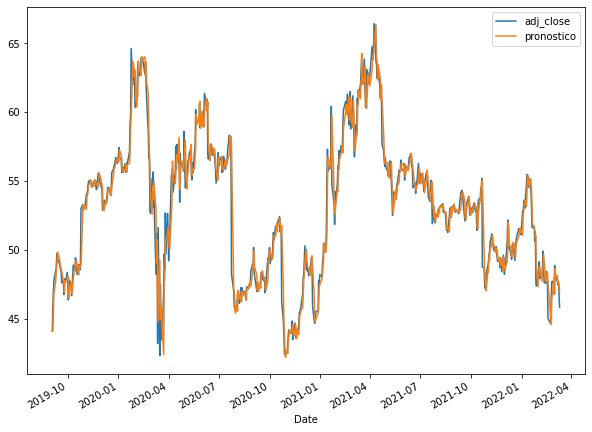

In [42]:
intel[['adj_close', 'pronostico']].plot()
plt.show()

In [31]:
#calculamos cuantas observaciones tenemos para hacer nuestra predicción
len(intel)

637

la función len nos arrojo que tenemos 637 observaciones,  quiere decir que el lunes sería la observación 638, el martes la 639, y el miércoles la 640

In [43]:
## vamos a pronosticar esos días
resultado2.predict(638, 640)

C:\Users\aaron\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


638    45.897618
639    45.909929
640    45.861329
Name: predicted_mean, dtype: float64

mi pronostico para el lunes 14 de marzo es que la acción de intel tenga un precio de cierre (ajustado) de 45.897618

El viernes cerro en 45.83